In [2]:
!pip install numpy opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   - -------------------------------------- 1.0/39.5 MB 10.1 MB/s eta 0:00:04
   --- ------------------------------------ 3.1/39.5 MB 10.8 MB/s eta 0:00:04
   ----- ---------------------------------- 5.8/39.5 MB 11.4 MB/s eta 0:00:03
   -------- ------------------------------- 8.1/39.5 MB 11.4 MB/s eta 0:00:03
   ---------- ----------------------------- 10.5/39.5 MB 11.5 MB/s eta 0:00:03
   ------------- -------------------------- 12.8/39.5 MB 11.5 MB/s eta 0:00:03
   --------------- ------------------------ 15.5/39.5 MB 11.6 MB/s eta 0:00:03
   ------------------ --------------------- 17.8/39.5 MB 11.6 MB/s eta 0:00:02
   -------------------- ------------------- 20.2/39.5 MB 11.6 MB/s eta 0:00:02
   ---------------------- ----------------- 22.5/39.5 MB 11.6 MB/s eta 0:00:02
   ------------------------- -------------- 25.2/39.5 MB 11.6 MB/s eta 0:00:02
   --------------------------- ------------ 27.5/39.5 MB 11.6 MB/

In [235]:
import cv2
import numpy as np
import zlib
import os
import matplotlib.pyplot as plt

# Предикторы
# ......................
# .... | C | B | D | ...
# .... | A | X |   | ...   
# ......................
# X - предсказываемый пиксель

# Пустой предиктор 
def predictor_none(row: int, col: int, image: np.ndarray) -> int:
    return 0

# Левый предиктор: predict(A)
def predictor_left(row: int, col: int, image: np.ndarray) -> int:
    return int(image[row, col - 1]) if col > 0 else 0

# Верхний предиктор: predict(B)
def predictor_up(row: int, col: int, image: np.ndarray) -> int:
    return int(image[row - 1, col]) if row > 0 else 0

# Срднее: predict((A + B) / 2)
def predictor_average(row: int, col: int, image: np.ndarray) -> int:
    a = predictor_left(row, col, image)
    b = predictor_up(row, col, image)
    return (a + b) // 2

# Ближайшая из A,B,C к A + B - C
def predictor_paeth(row: int, col: int, image: np.ndarray) -> int:
    a = predictor_left(row, col, image)
    b = predictor_up(row, col, image)
    c = int(image[row - 1, col - 1]) if row > 0 and col > 0 else 0
    p = a + b - c
    pa, pb, pc = abs(p - a), abs(p - b), abs(p - c)
    return a if pa <= pb and pa <= pc else b if pb <= pc else c

# Предикторы, из которых выбираем для каждого пикселя свой
PREDICTORS = [
    predictor_none, 
    predictor_left, 
    predictor_up,
    predictor_average,
    predictor_paeth
]

# По изображению находим его сериализованную матрицу ошибок
def image2residuals(image: np.ndarray, N=10) -> np.ndarray:
    """
    Кодирует изображение в вектор остатков (residuals),
    при этом первый пиксель не предсказывается, а сохраняется как есть.

    Параметры:
        image - grayscale изображение (uint8)
        N - глубина окна ошибок для адаптивного выбора предиктора

    Возвращает:
        1D-массив остатков (int16)
    """
    if len(image.shape) != 2:
        raise ValueError("Only grayscale images are supported")
    
    image = image.astype(np.int16)
    h, w = image.shape
    prediction_image = np.zeros_like(image, dtype=np.int16)
    residuals = np.zeros_like(image, dtype=np.int16)

    for row in range(h):
        row_errors = np.zeros((N, len(PREDICTORS)))

        for col in range(w):
            actual = int(image[row, col])

            if col == 0:
                if row == 0:
                    # Первый пиксель всего изображения сохраняем как есть
                    prediction_image[row, col] = 0
                    residuals[row, col] = actual
                else:
                    # Предсказываем первый пиксель строки по верху
                    pred = predictor_up(row, col, image)
                    prediction_image[row, col] = pred
                    residuals[row, col] = actual - pred
                continue

            # Выбираем лучший предиктор по средним ошибкам за последние N шагов
            if col > 1:
                row_means = row_errors[0:min(col, N), :].mean(axis=0)
                best_idx = int(np.argmin(row_means))
            else:
                best_idx = 1

            pred = PREDICTORS[best_idx](row, col, image)
            prediction_image[row, col] = pred
            residuals[row, col] = actual - pred

            # Обновляем матрицу ошибок
            row_errors = np.roll(row_errors, shift=1, axis=0)
            for k, fn in enumerate(PREDICTORS):
                p = fn(row, col, image)
                row_errors[0, k] = (actual - p) ** 2

    return residuals.reshape(-1)

# По одномерной матрице ошибок и размерам изображения находим изображение
def residuals2image(residuals: np.ndarray, h: int, w: int, N=10) -> np.ndarray:
    """
    Восстанавливает изображение из массива остатков.
    Первый пиксель восстанавливается напрямую,
    остальные — по предсказаниям и остаткам.

    Параметры:
        residuals — 1D массив остатков (int16)
        h, w — размеры изображения
        N — глубина окна ошибок

    Возвращает:
        Восстановленное изображение (uint8)
    """
    residuals = residuals.reshape((h, w))
    image = np.zeros((h, w), dtype=np.int16)

    for row in range(h):
        row_errors = np.zeros((N, len(PREDICTORS)))

        for col in range(w):
            if col == 0:
                if row == 0:
                    # Первый пиксель всего изображения восстанавливаем напрямую
                    image[row, col] = residuals[row, col]
                else:
                    # Предсказываем первый пиксель строки по верху
                    pred = predictor_up(row, col, image)
                    image[row, col] = pred + residuals[row, col]
                continue

            if col > 1:
                row_means = row_errors[0:min(col, N), :].mean(axis=0)
                best_idx = int(np.argmin(row_means))
            else:
                best_idx = 1

            pred = PREDICTORS[best_idx](row, col, image)
            image[row, col] = pred + residuals[row, col]

            # Обновляем ошибки
            row_errors = np.roll(row_errors, shift=1, axis=0)
            for k, fn in enumerate(PREDICTORS):
                p = fn(row, col, image)
                row_errors[0, k] = (image[row, col] - p) ** 2

    return np.clip(image, 0, 255).astype(np.uint8)


if __name__ == "__main__":

    img = cv2.imread("example.jpg")
    if img is None:
        raise FileNotFoundError("example.jpg not found")

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("exapmle_gray.jpg", img_gray)
    print("Оригинальный размер:", img_gray.shape)

    N = 10

    residuals = image2residuals(img_gray, N)

    reconstructed_image = residuals2image(residuals, img_gray.shape[0], img_gray.shape[1], N)
    
    print("Совпадает ли восстановленное изображение с оригиналом?", np.allclose(img_gray, reconstructed_image))

Оригинальный размер: (441, 660)
Совпадает ли восстановленное изображение с оригиналом? True


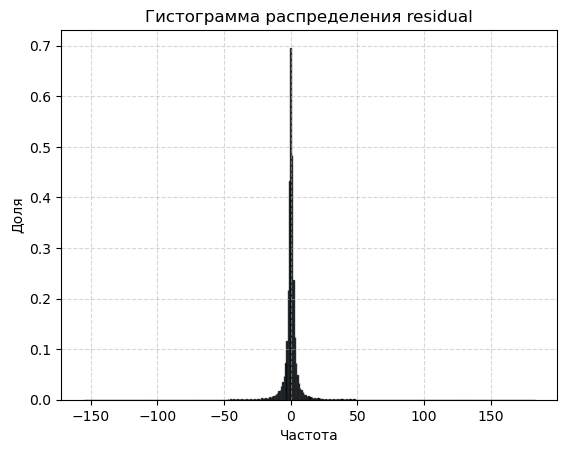

In [236]:
import matplotlib.pyplot as plt

plt.hist(residuals, bins=1000, edgecolor='black', alpha=0.8, density=True)
plt.title('Гистограмма распределения residual')
plt.xlabel('Частота')
plt.ylabel('Доля')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [237]:
import numpy as np
import zlib

residuals_bytes = residuals.tobytes()
compressed_data = zlib.compress(residuals_bytes)

decompressed_bytes = zlib.decompress(compressed_data)
residuals_restored = np.frombuffer(decompressed_bytes, dtype=np.int16)

print("Исходный размер (байт):", len(residuals_bytes))
print("Сжатый размер (байт):", len(compressed_data))
print("Восстановлено корректно?", np.array_equal(residuals, residuals_restored))

Исходный размер (байт): 582120
Сжатый размер (байт): 188760
Восстановлено корректно? True


In [249]:
compressed_bit = len(compressed_data) * 8
decompressed_bit = img_gray.shape[0] * img_gray.shape[1] * 8

print("Размер исходной картины (бит):", compressed_bit)
print("Размер полученного изображения (бит):", decompressed_bit)
print("Сжало на :", decompressed_bit / compressed_bit)

Размер исходной картины (бит): 1510080
Размер полученного изображения (бит): 2328480
Сжало на : 1.5419580419580419
